<a href="https://colab.research.google.com/github/nolnolon/Transformer-Lab/blob/main/RoBERTa_MultiClass_EDA_%2B_FineTuning_%2B_Eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multiple Choice Open Question Classification with [RoBERTa](https://huggingface.co/FacebookAI/roberta-base) [3] on the open-question-type [dataset](https://huggingface.co/datasets/launch/open_question_type) [2].

#### **Challenges**: The dataset is severely class-imbalanced and pre-split into train-val-test subsets without stratification. To account for this, subsets are merged together and split anew, with equal proportions being attributed to each category.

#### **Model summary**:  

1.   Model type: RoBERTa [3].
2.   Matthews Correlation Coefficient and class-balanced accuracy. Test evaluation confirms that these metrics produce close results (0.76 for MCC and 0.75 for c-b accuracy), in line with [1].
3. No baseline.

In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

# Connect to T4 GPU.

if device_name != '/device:GPU:0':

  raise SystemError('Not connected to a GPU device')

print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
! pip install datasets
! pip install accelerate -U
! pip install transformers[torch] -U
! pip install huggingface_hub
! pip install tensorboard==2.11
! sudo apt-get install git-lfs --yes

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sn
import torch
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, matthews_corrcoef, classification_report
from sklearn.utils.class_weight import compute_class_weight
from datasets import load_dataset, concatenate_datasets
from huggingface_hub import HfFolder, notebook_login
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    AutoConfig,
)

#### Open Question Type dataset, introduced by [2] and downloaded [from Huggingface](https://huggingface.co/datasets/launch/open_question_type).

- Each textual input comprised of 1 sentence (small sequence)
- Singular labels
- 10 labels

Stats based on EDA below:
- Number of instances in the dataset: 4956.
- Percentages per split: train: 0.75, validation: 0.12, test: 0.13
- Max sequence length across splits: 216
- Annotators disagree in 36.0% of instances.
- Percentage of instances annotated with 2 different tags: 18.0%.
- Question types: ['concept', 'verification', 'procedural', 'comparison', 'cause', 'judgmental', 'example', 'disjunction', 'extent', 'consequence']

In [14]:
notebook_login()


In [4]:
repository_id = "nolnolon/roberta-finetune-open-question"
model_id = "roberta-base"
dataset_id = "launch/open_question_type"

In [37]:
dataset = load_dataset(dataset_id)

### Dataset summary:

In [6]:
# Original splits
train = pd.DataFrame(dataset['train'])
val = pd.DataFrame(dataset['validation'])
test = pd.DataFrame(dataset['test'])

In [7]:
# Maximum sequence length across train, validation and test splits.

all_seq_vals: list = []

for data in dataset.values():

  rows = data['question']

  seq_train = [len(row) for row in rows ]
  max_seq_train = max(seq_train)
  all_seq_vals.append(max_seq_train)

max_seq = max(all_seq_vals)


# The number of instances where annotator 1 and annotator 2 disagree

disagree_inst: list = []
disagree_times: int = 0

for data in dataset.values():

  ann1 = data['annotator1']
  ann2 = data['annotator2']

  for row1, row2 in zip(ann1, ann2):

    if row1 != row2:

      disagree_times += 1
      disagree_inst.append(disagree_inst)

data_length = dataset.num_rows['train'] + dataset.num_rows['validation'] + dataset.num_rows['test']

perc_disagree = round(disagree_times / data_length, 2)

# Checking the number of instances with double annotaion

double_annot: int = 0

for data in dataset.values():

  ann1 = data['annotator1']
  ann2 = data['annotator2']

  for row1, row2 in zip(ann1, ann2):
    row1 = list(row1)
    row2 = list(row2)

    if ((len(row1) > 1) and (row1[1] != None)) or ((len(row2) > 1) and (row2[1] != None)):
      double_annot +=1

rounded_double_annot = round(double_annot/data_length,2)
labels = np.unique(dataset['train']['resolve_type'])
num_labels = len(labels)

print(f'Number of instances in the dataset: {data_length}.\nPercentages per split: train: {round(len(train)/data_length, 2)}, validation: {round(len(val)/data_length, 2)}, test: {round(len(test)/data_length, 2)}')
print(f"\nMax sequence length across splits: {max_seq}")
print(f"\nThe annotators disagree in {perc_disagree*100}% of instances.")
print(f"Percentage of instances annotated with 2 different tags: {rounded_double_annot*100}%.")
print(f"Unique labels: {num_labels}")
print(f"Label names: {labels}")

Number of instances in the dataset: 4956.
Percentages per split: train: 0.75, validation: 0.12, test: 0.13

Max sequence length across splits: 216

The annotators disagree in 36.0% of instances.
Percentage of instances annotated with 2 different tags: 18.0%.
Unique labels: 10
Label names: ['cause' 'comparison' 'concept' 'consequence' 'disjunction' 'example'
 'extent' 'judgmental' 'procedural' 'verification']


<ipython-input-8-e1843d7b3125>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90)
<ipython-input-8-e1843d7b3125>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax1.get_xticklabels(), rotation = 90)
<ipython-input-8-e1843d7b3125>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(ax1.get_xticklabels(), rotation = 90)


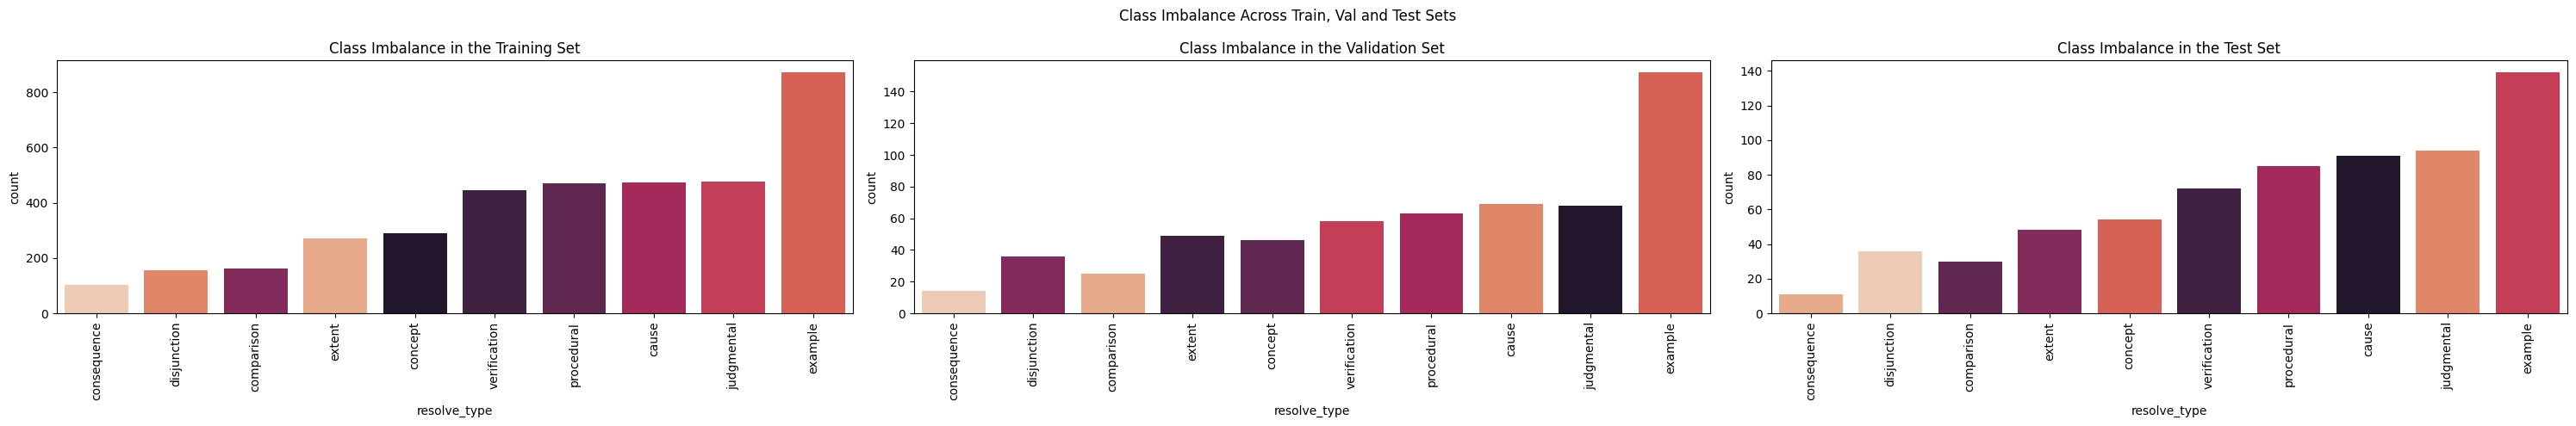

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30,5))
fig.suptitle('Class Imbalance Across Train, Val and Test Sets')

sn.countplot(data = train, x = 'resolve_type', palette = "rocket", saturation = 0.75, fill = True, hue = 'resolve_type', capsize = 3, ax = ax1, order = train['resolve_type'].value_counts(ascending = True).index)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90)
ax1.set_title("Class Imbalance in the Training Set")

sn.countplot(data = val, x = 'resolve_type', palette = "rocket", saturation = 0.75, fill = True, hue = 'resolve_type', capsize = 3, ax = ax2, order = train['resolve_type'].value_counts(ascending = True).index)
ax2.set_xticklabels(ax1.get_xticklabels(), rotation = 90)
ax2.set_title("Class Imbalance in the Validation Set")

sn.countplot(data = test, x = 'resolve_type', palette = "rocket", saturation = 0.75, fill = True, hue = 'resolve_type', capsize = 3, ax = ax3, order = train['resolve_type'].value_counts(ascending = True).index)
ax3.set_xticklabels(ax1.get_xticklabels(), rotation = 90)
ax3.set_title("Class Imbalance in the Test Set")

plt.tight_layout()
plt.show()

### Dataset preprocessing

In [38]:
dataset = dataset.select_columns(['question', 'resolve_type'])
# Renaming the columns to meet conventions dataset.rename_column("sentence1", "sentenceA")
dataset = dataset.rename_column("question", "text")
dataset = dataset.rename_column("resolve_type", "label")

# Merging the dataset
dataset = concatenate_datasets([dataset['train'], dataset['validation'], dataset['test']])

# Encode the label column
dataset = dataset.class_encode_column("label")

dataset[0]

{'text': 'When two bacteria exchange genetic information, what is the process called?',
 'label': 2}

## Preprocessing: tokenization and class encoding

In [39]:
# Creating a stratified train-val-test split
dataset_dict = dataset.train_test_split(test_size=0.3, stratify_by_column='label', seed = 12)
train_val_dict = dataset_dict['train'].train_test_split(test_size=0.3, stratify_by_column='label', seed = 12)

train_dataset = train_val_dict['train']
val_dataset = train_val_dict['test']
test_dataset = dataset_dict['test']

In [40]:
# Preprocessing
tokenizer = RobertaTokenizerFast.from_pretrained(model_id)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
val_dataset = val_dataset.map(tokenize, batched=True, batch_size=len(val_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

# Setting each dataset into the correct format
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"]) # Commenting off due to eval format

# id2label mapping
id2label = {i: label for i, label in enumerate(labels)}
config = AutoConfig.from_pretrained(model_id)
config.update({"id2label": id2label})

Map:   0%|          | 0/1487 [00:00<?, ? examples/s]

In [12]:
#! huggingface-cli login

## Pretraining on train & val sets

In [23]:
# Defining accuracy metrics
def compute_metrics(y_pred):
    """
    Evaluates the quality of predictions through 2 accuracy metrics:
    balanced weighted accuracy and Matthews correlation coefficient.
    :param y_true: the true label.
    :param y_pred: the predicted label.
    :returns: a dictionary with:
              - balanced weighted accuracy,
              - Matthews correlation coefficient.
    """
    logits, labels = y_pred
    predictions = np.argmax(logits, axis=-1) # Most probable label
    bas = balanced_accuracy_score(y_true = labels, y_pred = predictions)    # Average of recall for each class
    mcc = matthews_corrcoef(y_true = labels, y_pred = predictions)
    return {
               'balanced weighted accuracy': bas,
               'mcc': mcc
    }

# Model
model = RobertaForSequenceClassification.from_pretrained(model_id, config=config, ignore_mismatched_sizes=True)

# Training arguments
training_args = TrainingArguments(
    output_dir = repository_id,
    logging_dir = f"{repository_id}/logs",
    logging_strategy = "steps",
    logging_steps = 10,
    num_train_epochs = 5,
    save_strategy = "epoch",
    evaluation_strategy = "epoch",
    per_device_train_batch_size = 8, # Same train and eval sizes
    per_device_eval_batch_size = 8,  # Same train and eval sizes
    learning_rate = 5e-5,
    weight_decay = 0.01,
    warmup_steps = 500,
    save_total_limit = 2,
    load_best_model_at_end = True,
    push_to_hub = True,
    report_to = "tensorboard",
    hub_strategy = "every_save",
    hub_model_id = repository_id,
    hub_token = HfFolder.get_token(),
)

# Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    compute_metrics = compute_metrics
)

# Fine-tuning the model
trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Balanced weighted accuracy,Mcc
1,0.759100,0.872134,0.656456,0.691458
2,0.802000,0.870344,0.738720,0.725829
3,0.386300,0.761266,0.767400,0.783671
4,0.308800,0.811336,0.797157,0.787898
5,0.429200,0.915528,0.792291,0.796136


TrainOutput(global_step=1520, training_loss=0.6930089831842403, metrics={'train_runtime': 260.8847, 'train_samples_per_second': 46.534, 'train_steps_per_second': 5.826, 'total_flos': 274518547638720.0, 'train_loss': 0.6930089831842403, 'epoch': 5.0})

In [24]:
# Evaluating the model
trainer.evaluate()

{'eval_loss': 0.7612655162811279,
 'eval_balanced weighted accuracy': 0.7674004501879323,
 'eval_mcc': 0.7836705146957524,
 'eval_runtime': 2.7464,
 'eval_samples_per_second': 379.042,
 'eval_steps_per_second': 47.699,
 'epoch': 5.0}

In [26]:
# Storage repository_id
repository_id: str = './model_save'

# Tokenizer, model, model card
model.save_pretrained(repository_id)
tokenizer.save_pretrained(repository_id)
trainer.create_model_card()

# Push the results to the hub
trainer.push_to_hub()

events.out.tfevents.1714398543.ba54a8dc753c.985.7:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1714398841.ba54a8dc753c.985.8:   0%|          | 0.00/428 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/nolnolon/roberta-finetune-open-question/commit/91b43565a8a1cd977653761c6239d2d690d3a8ab', commit_message='End of training', commit_description='', oid='91b43565a8a1cd977653761c6239d2d690d3a8ab', pr_url=None, pr_revision=None, pr_num=None)

In [41]:
test_dataset[0]

{'label': tensor(7),
 'input_ids': tensor([    0, 31231,    38,    28,    19,   127,  7172,  1150,   114,   939,
           657,   123,     6,    53,    38,   216,    37,    40,   393,   146,
            10,   205,   301,    13,    69,   116,     2,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [44]:
from transformers import pipeline
# Initialize the pipeline
classifier = pipeline('text-classification', repository_id)

def decoded_input_to_prediction(test_dataset) -> tuple[list,list]:
  """
  Decodes the instances to match input format for the pipeline.
  :param test_dataset: the test subset.
  :returns: a tuple containing true labels and corresponding predictions.
  """
  # Iterate through the test dataset
  for ins in test_dataset:

      input_ids = ins['input_ids']
      attention_mask = ins['attention_mask']
      text = tokenizer.decode(input_ids, skip_special_tokens=True)

      result = classifier(text)
      ins_y_pred = result[0]['label']

      # Populating y_pred and y_true
      y_pred.append(ins_y_pred)
      y_true.append(ins['label'])

      return y_true, y_pred

y_true, y_pred = decoded_input_to_prediction(test_dataset)

## Evaluation

In [ ]:
y_true = [int(instance) for instance in y_true]
y_true = [id2label[id] for id in y_true]

In [64]:
bas = balanced_accuracy_score(y_true, y_pred)
bas

0.7544092319650332

In [66]:
mcc = matthews_corrcoef(y_true, y_pred)
mcc

0.7601928907440755

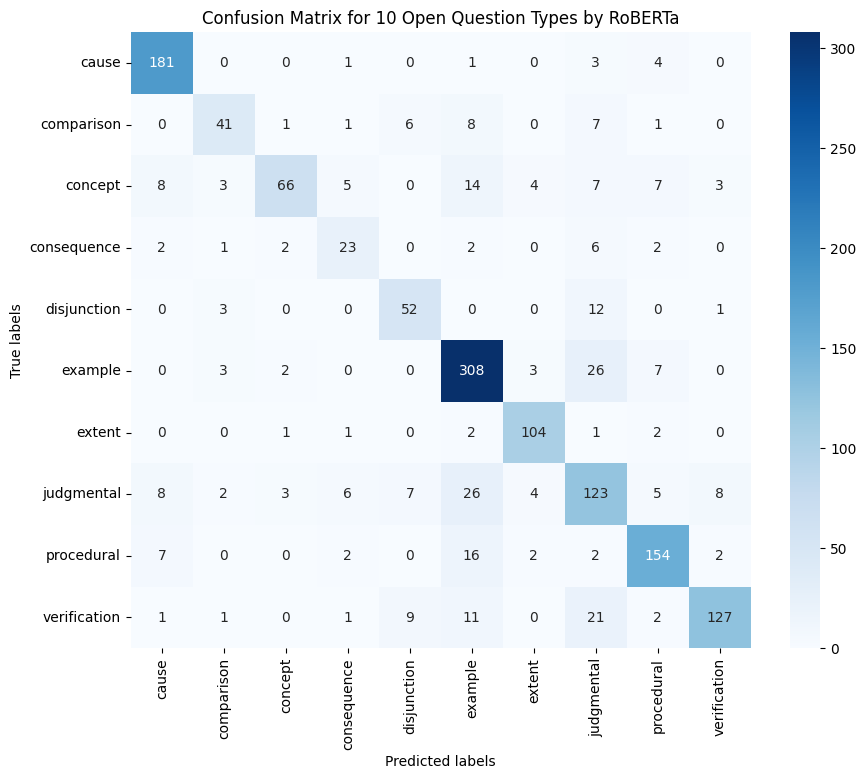

In [73]:
cmatrix = confusion_matrix(y_true, y_pred, labels=labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sn.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for 10 Open Question Types by RoBERTa')
plt.show()

###### Drawing on the materials offered as part of the course 'Text Mining for AI' by Ilia Markov and Piek Vossen ([Lab 6](https://github.com/cltl/ba-text-mining/tree/master/lab_sessions/lab6)), [Transformers Text Classifier Example](https://gist.github.com/jantrienes/329479bdad6b2a239cfcea83b9159a8a)  by Jan Trienes, [Company Classification Usign RoBERTa](https://github.com/Bicky23/Company-Classification-using-RoBERTa/tree/master) by Bijit Deka as well as Achilles Moraites's [Fine-tuning RoBERTa for Topic Classification](https://github.com/achimoraites/machine-learning-playground/blob/main/NLP/Text%20classification/RoBERTa_Finetuning.ipynb).


### References

[1] M. Grandini, E. Bagli, and G. Visani, ‘Metrics for Multi-Class Classification: an Overview’, arXiv [stat.ML]. 2020.

[2] S. Cao and L. Wang, ‘Controllable Open-ended Question Generation with A New Question Type Ontology’, in Proceedings of the 59th Annual Meeting of the Association for Computational Linguistics and the 11th International Joint Conference on Natural Language Processing (Volume 1: Long Papers), 2021, pp. 6424–6439.

[3] Y. Liu et al., ‘RoBERTa: A Robustly Optimized BERT Pretraining Approach’, arXiv [cs.CL]. 2019.
